In [1]:
%matplotlib inline
import random
import math
import torch
import time
import numpy
from d2l import torch as d2l

In [2]:
# 定时器
class Timer:
    """ 记录多次运行时间 """
    
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        """ 启动计时器 """
        self.tik = time.time()
        
    def stop(self):
        """ 停止计时器，并记录 """
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        """ 返回平均时间 """
        return sum(self.times) / len(self.times)
    
    def sum(self):
        """ 返回时间总和 """
        return sum(self.times)
    
    def cumsum(self):
        """ 返回累积时间 """
        return np.array(self.times).cumsum().tolist()

In [3]:
n = 10000
x = torch.ones([n])
y = torch.ones([n])
z = torch.zeros(n)
timer = Timer()
for i in range(n):
    z[i] = x[i] + y[i]
f'{timer.stop():.5f} sec'

'0.12805 sec'

In [4]:
timer.start()
z = x + y
f'{timer.stop():.5f} sec'

'0.00000 sec'

In [5]:
# 计算正态分布
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

In [6]:
# 生成数据集
# 生成一个包含1000个样本的数据集， 每个样本包含从标准正态分布中采样的2个特征
def synthetic_data(w, b, num_examples):
    """ 生成y = Xw + b + 噪声 """
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.8298,  1.2122]) 
label: tensor([-1.5754])


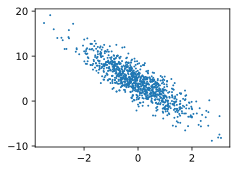

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [8]:
def data_iter(batch_size, features, labels):
    """ 抽取小样本，更新模型 """
    num_examples = len(features)
    indices = list(range(num_examples))
    # 随机读取
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.3507, -1.5413],
        [-0.6332,  1.3638],
        [-0.6881,  0.1518],
        [-1.0418,  0.2994],
        [-1.1865,  0.3209],
        [ 1.1210,  2.5316],
        [-1.2972, -0.4277],
        [ 0.6344, -0.9233],
        [-0.5126,  0.0219],
        [ 0.3321,  0.2285]]) 
 tensor([[ 6.7400],
        [-1.7155],
        [ 2.3063],
        [ 1.0834],
        [ 0.7456],
        [-2.1710],
        [ 3.0596],
        [ 8.6077],
        [ 3.1027],
        [ 4.0885]])


In [9]:
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [10]:
# 定义模型
def linreg(X, w, b):
    """ 线性回归模型 """
    return torch.matmul(X, w) + b

In [11]:
# 定义损失函数
def squared_loss(y_hat, y):
    """ 均方损失 """
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [12]:
# 定义优化算法
def sgd(params, lr, batch_size):
    """ 小批量随机梯度下降 """
    with torch.no_grad():  # 在更新参数时，禁用梯度计算
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            

In [13]:
# 训练
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # 小批量损失
        l.sum().backward()  # l是一个矢量，所以加到一起来计算梯度
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_loss = loss(net(features, w, b), labels)
        print(train_loss.shape)
        print(f'epoch{epoch + 1}, loss {float(train_loss.mean()):f}')
        

torch.Size([1000, 1])
epoch1, loss 0.033908
torch.Size([1000, 1])
epoch2, loss 0.000127
torch.Size([1000, 1])
epoch3, loss 0.000053


In [14]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([ 0.0009, -0.0005], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0005], grad_fn=<RsubBackward1>)


In [15]:
del net, loss, l
del w, b, true_w, true_b

In [34]:
# 使用pytorch简洁实现
true_w = torch.tensor([2, -3.4])
true_b = 4.2
print(f"w: {true_w}, b: {true_b }")
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

w: tensor([ 2.0000, -3.4000]), b: 4.2


In [35]:
# 读取数据集
def load_array(data_array, batch_size, is_train=True):
    """ 构造一个PyTorch数据迭代器 """
    dataset = torch.utils.data.TensorDataset(*data_array)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size = 10
data_iter = load_array((features, labels), batch_size)
print(type(data_iter))

<class 'torch.utils.data.dataloader.DataLoader'>


In [36]:
next(iter(data_iter))

[tensor([[-0.2225,  0.6810],
         [-1.0064, -0.9080],
         [-0.9365,  1.1966],
         [ 0.1425,  0.7637],
         [ 1.2085, -1.0199],
         [-0.4696, -1.3379],
         [ 0.8705, -0.0209],
         [ 0.6825, -0.4635],
         [-1.7925,  1.6755],
         [ 1.0122, -0.0705]]),
 tensor([[ 1.4406],
         [ 5.2742],
         [-1.7320],
         [ 1.8810],
         [10.1036],
         [ 7.8041],
         [ 6.0095],
         [ 7.1371],
         [-5.0842],
         [ 6.4754]])]

In [37]:
# 定义模型
net = torch.nn.Sequential(torch.nn.Linear(2, 1))
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
print(net)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)


In [38]:
# 定义损失函数
loss = torch.nn.MSELoss()
print(loss)

MSELoss()


In [39]:
# 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)
print(trainer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [40]:
# 训练
num_epochs = 10
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)  # 计算损失
        trainer.zero_grad()  # 清楚之前的梯度
        l.backward()  # 反向传播计算梯度
        trainer.step()  # 更新参数
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000221
epoch 2, loss 0.000103
epoch 3, loss 0.000103
epoch 4, loss 0.000103
epoch 5, loss 0.000102
epoch 6, loss 0.000103
epoch 7, loss 0.000103
epoch 8, loss 0.000102
epoch 9, loss 0.000102
epoch 10, loss 0.000103


In [41]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0004, -0.0003])
b的估计误差： tensor([0.0004])
